In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from scipy import stats
import patsy
from sklearn.feature_selection import VarianceThreshold
from sklearn import manifold
from sklearn.manifold import TSNE

# load datasest

In [2]:
#using gene id, since name might same， and make sure use trainning set
df_train = pd.read_csv('~/D2K_BCM_DATASET/train_final_90%.tsv', sep='\t',index_col=0)
df_train.shape # (58051, 407)

(58051, 407)

In [3]:
df_train.head()

,205_2,251_1,474_3,178_4,313_1,484_4,288_1,106_4,215_2,184_3,...,330_2,11_4,480_1,314_1,371_3,443_2,311_1,225_2,150_4,289_2
ENSG00000000003,273.0,192.0,170.0,157.0,192.0,279.0,160.0,127.0,209.0,159.0,...,180.0,224.0,166.0,237.0,191.0,263.0,184.0,186.0,401.0,101.0
ENSG00000000005,1.0,1.0,1.0,3.0,2.0,1.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
ENSG00000000419,202.0,243.0,230.0,270.0,232.0,231.0,174.0,164.0,244.0,207.0,...,257.0,274.0,230.0,327.0,252.0,285.0,237.0,223.0,278.0,159.0
ENSG00000000457,261.0,369.0,355.0,375.0,317.0,273.0,254.0,198.0,229.0,344.0,...,335.0,297.0,348.0,389.0,461.0,272.0,419.0,376.0,312.0,380.0
ENSG00000000460,194.0,188.0,234.0,236.0,385.0,154.0,144.0,253.0,218.0,214.0,...,331.0,198.0,192.0,274.0,251.0,322.0,364.0,129.0,322.0,252.0


In [4]:
#load 18k normalized data 
df_s = pd.read_csv('~/D2K_BCM_DATASET/filtered_cpm_tmmnorm.csv',index_col=0)
df_s.shape #(18620,453)

(18620, 453)

In [5]:
#load annotation dataset
anno = pd.read_csv('~/D2K_BCM_DATASET/AnnotationFile.tsv', sep = '\t', index_col = [0])
#anno.head()

In [6]:
#load GWAS dataset
amd = pd.read_csv('~/D2K_BCM_DATASET/annogene.tsv', encoding = 'mac_roman')
amd = amd.set_index('external_gene_name')
#amd.head()

In [7]:
#load DE dataset
de = pd.read_csv('~/D2K_BCM_DATASET/annoDE .tsv', encoding = 'mac_roman')
de = de.set_index('external_gene_name')
#de.head()

In [8]:
##load meta retina dataset
retina = pd.read_csv('~/D2K_BCM_DATASET/meta_retina.csv', index_col = [0])
sub_retina = pd.DataFrame(retina,columns = ['age','sex','mgs_level'])
#sub_retina.head()

# Normalize across the column (by patient) to remove library depth effect and do log2(1+) transformatiom


In [9]:
## get the sum for the column
sum_col = df_train.sum(axis=0)
#sum_col.head()

## sum across the column, then divide by each library depth
new_df = df_train.div(df_train.sum(axis=0), axis=1)

## get the maximum of library depth
max_ld = df_train.sum(axis=0).max()
max_ld

## multiply by the largest library depth value
new_df2 = new_df.multiply(max_ld)

##log2(1+mrna_counts) transformation
new_df2 = np.log2(1+new_df2)
new_df2.head()

,205_2,251_1,474_3,178_4,313_1,484_4,288_1,106_4,215_2,184_3,...,330_2,11_4,480_1,314_1,371_3,443_2,311_1,225_2,150_4,289_2
ENSG00000000003,9.698730,9.181011,8.998180,8.623853,9.265740,9.812162,9.437012,8.940148,9.546959,8.747124,...,8.655932,9.646710,9.167614,9.394952,8.970498,9.652843,9.127804,9.243243,10.421857,8.767342
ENSG00000000005,2.014479,2.006454,2.000752,3.090678,2.887836,2.076766,3.805056,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.939756,0.000000,0.000000,2.012542,2.088428,0.000000,2.407193
ENSG00000000419,9.264794,9.520340,9.433543,9.404517,9.538354,9.540124,9.557860,9.308353,9.770061,9.126949,...,9.168631,9.937059,9.637367,9.858766,9.369653,9.768604,9.492408,9.504589,9.893805,9.420805
ENSG00000000457,9.633959,10.122333,10.058993,9.877852,9.988192,9.780834,10.102998,9.579767,9.678635,9.858699,...,9.550440,10.053232,10.234206,10.108998,10.240007,9.701328,10.313601,10.257470,10.060101,10.676553
ENSG00000000460,9.206593,9.150691,9.458382,9.210651,10.268317,8.956130,9.285240,9.932994,9.607705,9.174845,...,9.533134,9.468949,9.377198,9.603952,9.363925,9.944513,10.110761,8.716363,10.105573,10.084425


# Low Variance filtering

In [10]:
##calculate variance for each row
new_df2['var'] = new_df2.var(axis = 1)
new_df2.head()

,205_2,251_1,474_3,178_4,313_1,484_4,288_1,106_4,215_2,184_3,...,11_4,480_1,314_1,371_3,443_2,311_1,225_2,150_4,289_2,var
ENSG00000000003,9.698730,9.181011,8.998180,8.623853,9.265740,9.812162,9.437012,8.940148,9.546959,8.747124,...,9.646710,9.167614,9.394952,8.970498,9.652843,9.127804,9.243243,10.421857,8.767342,0.165981
ENSG00000000005,2.014479,2.006454,2.000752,3.090678,2.887836,2.076766,3.805056,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.939756,0.000000,0.000000,2.012542,2.088428,0.000000,2.407193,1.709223
ENSG00000000419,9.264794,9.520340,9.433543,9.404517,9.538354,9.540124,9.557860,9.308353,9.770061,9.126949,...,9.937059,9.637367,9.858766,9.369653,9.768604,9.492408,9.504589,9.893805,9.420805,0.097100
ENSG00000000457,9.633959,10.122333,10.058993,9.877852,9.988192,9.780834,10.102998,9.579767,9.678635,9.858699,...,10.053232,10.234206,10.108998,10.240007,9.701328,10.313601,10.257470,10.060101,10.676553,0.141133
ENSG00000000460,9.206593,9.150691,9.458382,9.210651,10.268317,8.956130,9.285240,9.932994,9.607705,9.174845,...,9.468949,9.377198,9.603952,9.363925,9.944513,10.110761,8.716363,10.105573,10.084425,0.170521


Text(0, 0.5, 'numbers of genes')

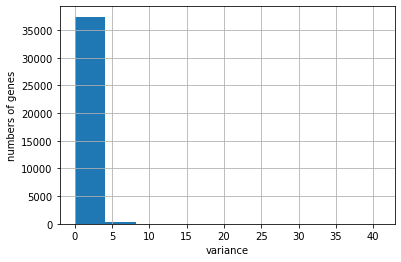

In [11]:
##histogram for variance grater threshold = 0.05
var = new_df2.var(axis=1)
var = var.loc[var>= 0.05]
ax = var.hist()
ax.set_xlabel("variance")
ax.set_ylabel("numbers of genes")


In [12]:
#get filtered frame
"""
1)threshold 0.05, 36k genes, ~17k overlapped
2)threshold 0.1, 31k genes, ~15k overlapped
"""
low_var = new_df2[new_df2['var'] >= 0.05]
low_var.shape

(36797, 408)

In [13]:
## check the overlap with tmm nomalized data
low_var_ind = low_var.index
s_ind = df_s.index
count = 0 
for i in low_var_ind:
    if i in s_ind:
        count += 1
count

17683

# Dataframe after low_var filtering: df. shape (36797, 407)


In [14]:
dfn = pd.DataFrame()
dfn = low_var.drop(['var'],axis = 1)
dfn.head()

,205_2,251_1,474_3,178_4,313_1,484_4,288_1,106_4,215_2,184_3,...,330_2,11_4,480_1,314_1,371_3,443_2,311_1,225_2,150_4,289_2
ENSG00000000003,9.698730,9.181011,8.998180,8.623853,9.265740,9.812162,9.437012,8.940148,9.546959,8.747124,...,8.655932,9.646710,9.167614,9.394952,8.970498,9.652843,9.127804,9.243243,10.421857,8.767342
ENSG00000000005,2.014479,2.006454,2.000752,3.090678,2.887836,2.076766,3.805056,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.939756,0.000000,0.000000,2.012542,2.088428,0.000000,2.407193
ENSG00000000419,9.264794,9.520340,9.433543,9.404517,9.538354,9.540124,9.557860,9.308353,9.770061,9.126949,...,9.168631,9.937059,9.637367,9.858766,9.369653,9.768604,9.492408,9.504589,9.893805,9.420805
ENSG00000000457,9.633959,10.122333,10.058993,9.877852,9.988192,9.780834,10.102998,9.579767,9.678635,9.858699,...,9.550440,10.053232,10.234206,10.108998,10.240007,9.701328,10.313601,10.257470,10.060101,10.676553
ENSG00000000460,9.206593,9.150691,9.458382,9.210651,10.268317,8.956130,9.285240,9.932994,9.607705,9.174845,...,9.533134,9.468949,9.377198,9.603952,9.363925,9.944513,10.110761,8.716363,10.105573,10.084425


# Anova Analysis 


In [15]:
## Split the data into different groups for ANOVA testing
train_stage1 = {}
train_stage2 = {}
train_stage3 = {}
train_stage4 = {}

for col in dfn.columns:
    if '_1' in col:
        train_stage1[col] = dfn[col]
    elif '_2' in col:
        train_stage2[col] = dfn[col]
    elif '_3' in col:
        train_stage3[col] = dfn[col]
    elif '_4' in col:
        train_stage4[col] = dfn[col]

train_stage1 = pd.DataFrame(train_stage1).transpose()
train_stage2 = pd.DataFrame(train_stage2).transpose()
train_stage3 = pd.DataFrame(train_stage3).transpose()
train_stage4 = pd.DataFrame(train_stage4).transpose()

train_all = pd.concat([train_stage1,train_stage2,train_stage3,train_stage4])
train_all.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000283662,ENSG00000283667,ENSG00000283674,ENSG00000283683,ENSG00000283684,ENSG00000283689,ENSG00000283692,ENSG00000283696,ENSG00000283697,ENSG00000283698
251_1,9.181011,2.006454,9.520340,10.122333,9.150691,5.531974,8.107547,8.480250,10.224124,10.513412,...,4.652112,5.531974,6.358106,0.000000,0.0,0.000000,2.814728,2.006454,0.0,2.006454
313_1,9.265740,2.887836,9.538354,9.988192,10.268317,5.517628,9.071543,8.237808,10.334186,11.223999,...,2.887836,6.692449,6.282053,0.000000,0.0,2.070663,4.087801,2.070663,0.0,0.000000
288_1,9.437012,3.805056,9.557860,10.102998,9.285240,5.467900,8.840801,8.802736,10.573380,10.724879,...,3.805056,5.838869,7.251781,0.000000,0.0,0.000000,2.413026,0.000000,0.0,0.000000
115_1,9.130316,1.659856,9.686330,10.031174,9.190218,4.965226,7.926289,8.265375,10.183634,11.070155,...,3.560623,6.131655,5.600409,1.659856,0.0,0.000000,1.659856,2.902951,0.0,0.000000
307_1,9.199003,0.000000,9.937524,10.122836,9.343763,5.489926,9.398274,8.612094,11.009134,11.003696,...,4.045112,5.917626,5.854580,0.000000,0.0,0.000000,0.000000,3.799451,0.0,0.000000


In [16]:
## Perform Anova analysis
##One-Way ANOVA ("analysis of variance") compares the means of two or more independent groups 
##in order to determine whether there is statistical evidence 
##that the associated population means are significantly different. 

stats.f_oneway(train_stage1, train_stage2, train_stage3, train_stage4)

F_onewayResult(statistic=array([6.67017808, 0.31403824, 1.86281365, ..., 1.15267261, 0.08029714,
       1.44868574]), pvalue=array([2.10008349e-04, 8.15238380e-01, 1.35273610e-01, ...,
       3.27631250e-01, 9.70693405e-01, 2.28141421e-01]))

In [17]:
dfn.head()

,205_2,251_1,474_3,178_4,313_1,484_4,288_1,106_4,215_2,184_3,...,330_2,11_4,480_1,314_1,371_3,443_2,311_1,225_2,150_4,289_2
ENSG00000000003,9.698730,9.181011,8.998180,8.623853,9.265740,9.812162,9.437012,8.940148,9.546959,8.747124,...,8.655932,9.646710,9.167614,9.394952,8.970498,9.652843,9.127804,9.243243,10.421857,8.767342
ENSG00000000005,2.014479,2.006454,2.000752,3.090678,2.887836,2.076766,3.805056,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.939756,0.000000,0.000000,2.012542,2.088428,0.000000,2.407193
ENSG00000000419,9.264794,9.520340,9.433543,9.404517,9.538354,9.540124,9.557860,9.308353,9.770061,9.126949,...,9.168631,9.937059,9.637367,9.858766,9.369653,9.768604,9.492408,9.504589,9.893805,9.420805
ENSG00000000457,9.633959,10.122333,10.058993,9.877852,9.988192,9.780834,10.102998,9.579767,9.678635,9.858699,...,9.550440,10.053232,10.234206,10.108998,10.240007,9.701328,10.313601,10.257470,10.060101,10.676553
ENSG00000000460,9.206593,9.150691,9.458382,9.210651,10.268317,8.956130,9.285240,9.932994,9.607705,9.174845,...,9.533134,9.468949,9.377198,9.603952,9.363925,9.944513,10.110761,8.716363,10.105573,10.084425


# Perform AN0VA analysis on 4 group

In [18]:
## Get the list of p values out of the dataframe
p_vals = stats.f_oneway(train_stage1, train_stage2, train_stage3, train_stage4).pvalue

dfn = dfn.reset_index()

## Get the list of genes that these values correspond to
gene_list = dfn['index']

## Create list of (gene, p value) pairs
pairs = list(zip(gene_list, p_vals))

## Use liberal p value threshold
threshold_standard_all = list(filter(lambda x: x[1] <= 0.05, pairs))

## Use standard p-value threshold
"""
if threshold is 0.1, still same 
"""
threshold_liberal_all = list(filter(lambda x: x[1] <= 0.2, pairs))

print(len(threshold_standard_all))
print(len(list(threshold_liberal_all)))

4438
12160


# merge frames


In [19]:
#transform the list 4k genes -> dataframe
ths = pd.DataFrame(threshold_standard_all, columns =['index', 'pvalue']) 
ths = ths.set_index('index')
#ths.head() 

In [20]:
dfn = low_var.drop(['var'],axis = 1)
##filter the whole dataset 
test = dfn.join(ths)#
test= test.dropna(axis=0,how='any')

## get the 4k gene dataframe
EnsembleId4k = pd.DataFrame()
EnsembleId4k = test.drop(['pvalue'],axis = 1)
EnsembleId4k.head()


,205_2,251_1,474_3,178_4,313_1,484_4,288_1,106_4,215_2,184_3,...,330_2,11_4,480_1,314_1,371_3,443_2,311_1,225_2,150_4,289_2
ENSG00000000003,9.698730,9.181011,8.998180,8.623853,9.265740,9.812162,9.437012,8.940148,9.546959,8.747124,...,8.655932,9.646710,9.167614,9.394952,8.970498,9.652843,9.127804,9.243243,10.421857,8.767342
ENSG00000001036,9.007920,8.480250,8.114741,7.775116,8.237808,8.734221,8.802736,7.812934,8.635718,8.446249,...,7.721936,9.116281,7.985592,8.829168,8.227901,8.638124,8.374199,8.064653,9.482724,8.219190
ENSG00000001084,11.074547,10.224124,10.315019,10.114775,10.334186,10.764081,10.573380,10.772715,10.730303,9.904061,...,10.080694,10.763197,10.377201,10.699689,10.459993,10.507940,10.883195,10.112397,10.966361,10.162358
ENSG00000001629,11.255878,10.854084,10.832309,10.970147,11.156822,11.096485,11.127666,11.020680,11.193637,10.735507,...,10.585603,11.151072,10.856931,11.249491,10.694842,11.335497,11.187242,10.585284,11.653378,11.296214
ENSG00000001631,10.578447,10.851306,10.474078,10.669332,10.967349,10.729082,10.793857,10.508241,10.800190,10.507003,...,10.520417,10.851016,10.370320,10.941260,10.413145,10.911493,10.873519,10.214353,11.298931,10.920886


In [21]:
## get the csv file
#EnsembleId4k.to_csv("./4kEnsembleId.tsv",sep = '\t')

# Replace id with names

In [22]:
ftest = EnsembleId4k.join(anno)#
ftest = ftest.dropna(axis=0,how='any')
#ftest.shape

##replace index from id-> name 
ftest = ftest.set_index('external_gene_name')
ftest.head()

,205_2,251_1,474_3,178_4,313_1,484_4,288_1,106_4,215_2,184_3,...,311_1,225_2,150_4,289_2,chromosome_name,start_position,end_position,strand,gene_length,gene_biotype
external_gene_name,,,,,,,,,,,,,,,,,,,,,
TSPAN6,9.698730,9.181011,8.998180,8.623853,9.265740,9.812162,9.437012,8.940148,9.546959,8.747124,...,9.127804,9.243243,10.421857,8.767342,X,100627109,100639991,-1,4535.0,protein_coding
FUCA2,9.007920,8.480250,8.114741,7.775116,8.237808,8.734221,8.802736,7.812934,8.635718,8.446249,...,8.374199,8.064653,9.482724,8.219190,6,143494811,143511690,-1,2793.0,protein_coding
GCLC,11.074547,10.224124,10.315019,10.114775,10.334186,10.764081,10.573380,10.772715,10.730303,9.904061,...,10.883195,10.112397,10.966361,10.162358,6,53497341,53616970,-1,8463.0,protein_coding
ANKIB1,11.255878,10.854084,10.832309,10.970147,11.156822,11.096485,11.127666,11.020680,11.193637,10.735507,...,11.187242,10.585284,11.653378,11.296214,7,92246234,92401384,1,7130.0,protein_coding
KRIT1,10.578447,10.851306,10.474078,10.669332,10.967349,10.729082,10.793857,10.508241,10.800190,10.507003,...,10.873519,10.214353,11.298931,10.920886,7,92198969,92246166,-1,6204.0,protein_coding


In [23]:
## check whether 4k genes has duplicated name 
cd = pd.DataFrame()
cd = ftest
cd = cd.reset_index()
cd[cd.duplicated('external_gene_name')]

,external_gene_name,205_2,251_1,474_3,178_4,313_1,484_4,288_1,106_4,215_2,...,311_1,225_2,150_4,289_2,chromosome_name,start_position,end_position,strand,gene_length,gene_biotype
4220,SERPINA3,13.934494,11.534860,10.00737,10.6016,13.167563,12.498204,10.846698,12.536628,12.730418,...,12.025700,12.554409,14.365559,10.170356,14,94592058,94624646,1,3067.0,protein_coding
4311,Metazoa_SRP,2.014479,2.006454,0.00000,0.0000,0.000000,2.076766,2.413026,0.000000,0.000000,...,0.000000,0.000000,2.143544,0.000000,13,48429269,48429554,1,286.0,misc_RNA
4318,Y_RNA,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,2.316097,0.000000,0.000000,...,1.571774,0.000000,0.000000,0.000000,8,80484589,80484683,-1,95.0,misc_RNA
4341,Metazoa_SRP,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,14,55285227,55285558,1,332.0,misc_RNA


In [24]:
##get 4k genes(index is gene name) csv file
#test = ftest.drop(['pvalue','chromosome_name','start_position','end_position','strand','gene_length','gene_biotype'],axis = 1)
#test.to_csv("./4klog2Norm.tsv",sep = '\t')

In [25]:
## check how many DE/GWAS genes are in the 4k genes
low_var_ind = de.index
#low_var_ind = amd.index  
s_ind = ftest.index
count = 0 
for i in low_var_ind:
    if i in s_ind:
        count += 1
        print (i)
count
#with th 0.05 & 0.1 
#POU2AF1 MOXD1 PMAIP1 SLCO3A1

POU2AF1
MOXD1
PMAIP1
SLCO3A1


4

# heatmap 

In [26]:
#meaningful than tsne

In [27]:
test = EnsembleId4k.T

Text(0.5, 0.98, 'Gene_patient_Clusterheatmap')

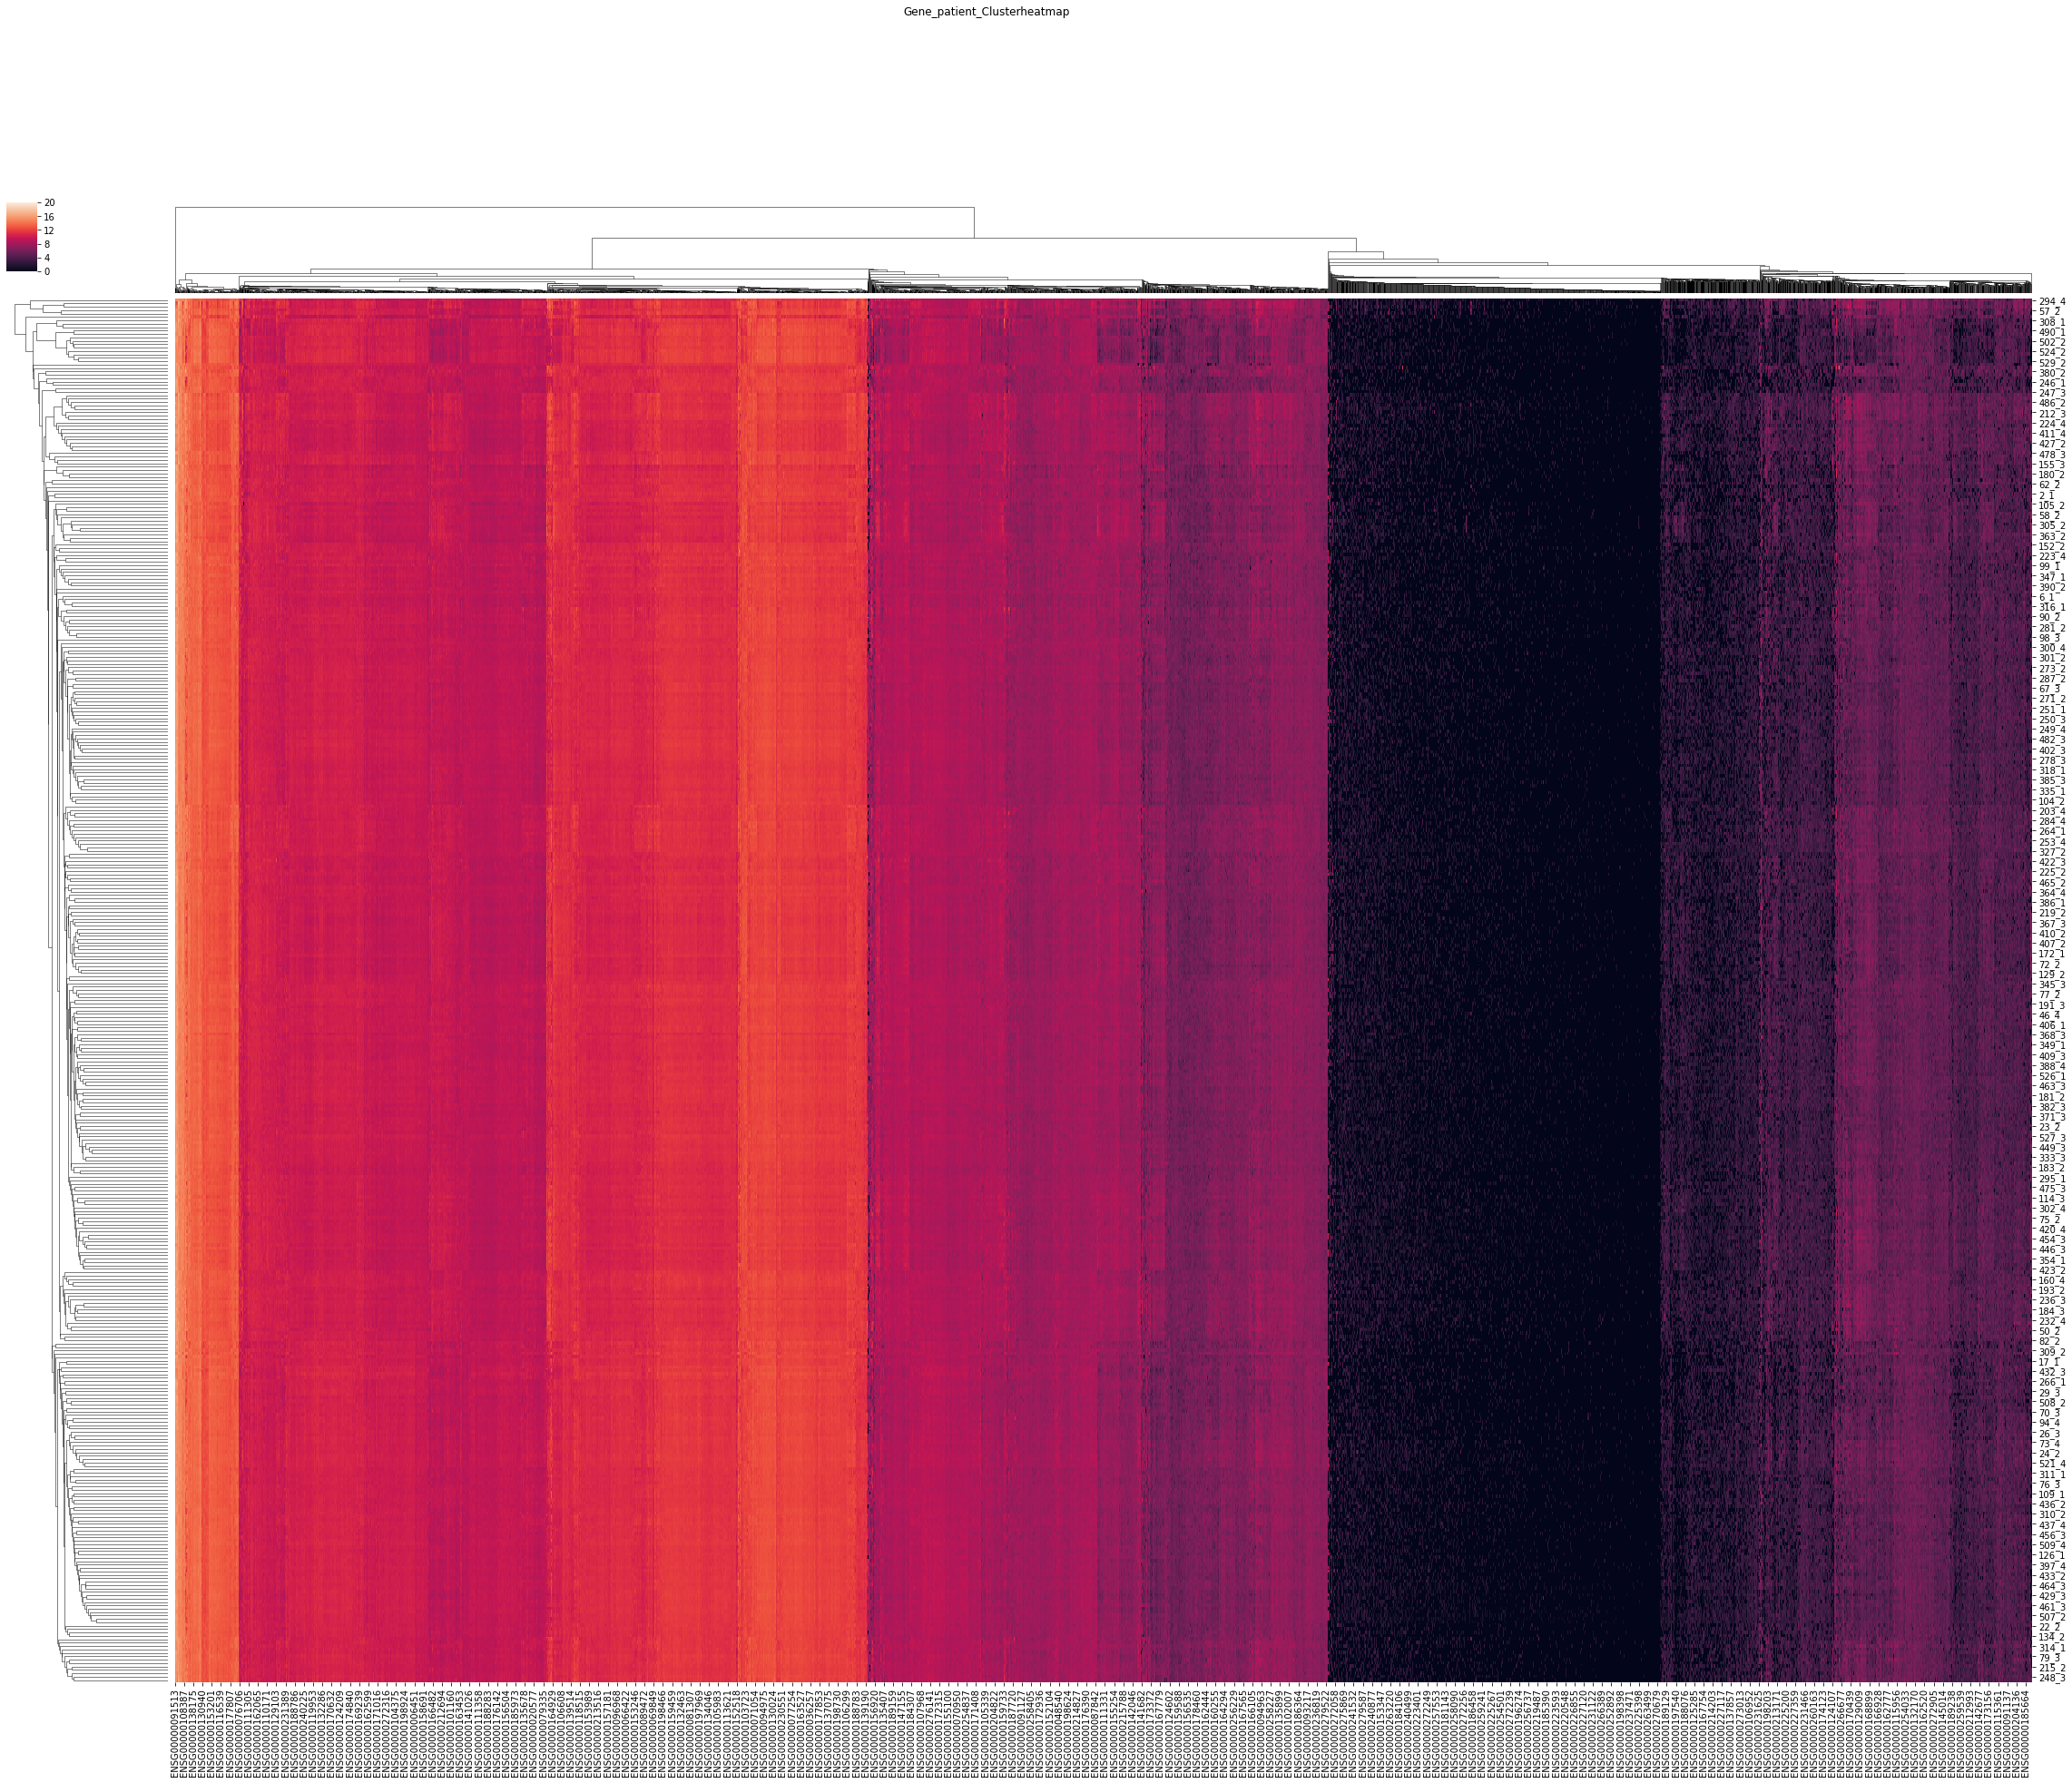

In [28]:
#althought did not show very clear cluster, at some cluster, there are no of stage 4 patients
g = sns.clustermap(test,figsize = (40,30))
g.fig.suptitle('Gene_patient_Clusterheatmap')

# TSNE

In [29]:
#dnt show clear cluster, make sense since difference between genes are small

In [30]:
dftsne = sub_retina.join(ftest.T)
fclean = dftsne.dropna(axis=0,how='any')
fclean.shape #(407,4441)

(407, 4441)

In [31]:
Y = TSNE(n_components = 2).fit_transform(fclean.drop(['age','sex','mgs_level'],axis=1))
fclean['tsne-2d-one'] = Y[:,0]
fclean['tsne-2d-two'] = Y[:,1]
fclean.head()

/Users/perception/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/perception/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,age,sex,mgs_level,TSPAN6,FUCA2,GCLC,ANKIB1,KRIT1,CD99,TMEM176A,...,RP11-248C1.4,RP11-84A14.6,RP11-1037J10.1,RP11-5O24.1,RP11-244E17.1,RP11-419I17.1,AC013271.5,RP11-158M9.1,tsne-2d-one,tsne-2d-two
r_id,,,,,,,,,,,,,,,,,,,,,
2_1,77.0,F,1,8.63819,8.46234,10.7519,11.1965,10.7234,7.92884,10.0007,...,0,0,0,0,3.52998,6.95534,0,3.00615,1.967669,-5.680573
4_1,88.0,F,1,9.55895,8.59249,10.1905,10.927,10.6434,8.71249,9.63685,...,2.37431,0,0,0,2.37431,6.66444,0,3.76071,-10.916818,-11.700816
6_1,73.0,F,1,8.53466,7.92291,10.2831,10.7773,10.2793,8.18131,9.41383,...,3.05721,0,0,0,2.22089,6.52866,0,0,2.702351,-4.160789
7_3,89.0,F,3,9.23104,8.67058,10.0008,10.9056,10.4372,8.67058,9.16488,...,0,0,0,0,3.06109,6.21839,0,3.43225,6.910272,6.291436
8_2,72.0,F,2,8.66616,7.91302,9.87539,10.5601,10.04,8.83323,9.02671,...,0,0,0,0,0,6.05443,0,3.37177,-7.836186,16.348276


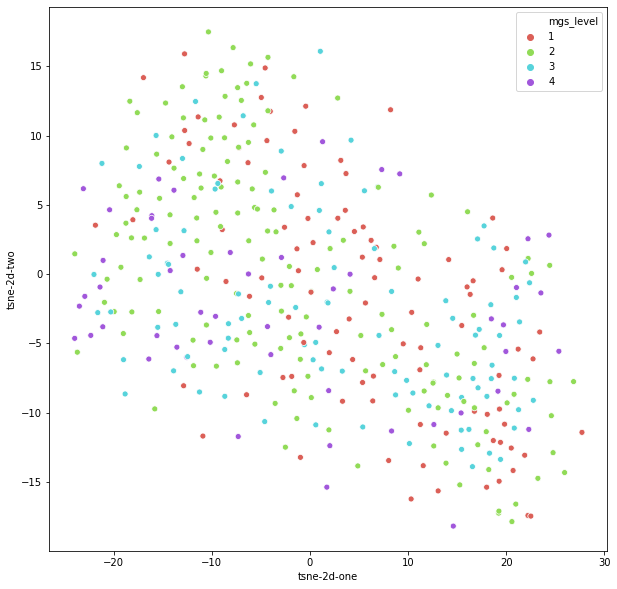

In [32]:
plt.figure(figsize = (10,10))
fig = sns.scatterplot(
    x = "tsne-2d-one", y ="tsne-2d-two", hue = "mgs_level",
    palette = sns.color_palette("hls",4),
    data = fclean
)
fig.figure.savefig("label mgs_level.png",dpi = 300)